[VAE](https://en.wikipedia.org/wiki/Variational_autoencoder)

[Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

## GP 1D Data Generator

In [1]:
#import os,sys
#sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
import numpy as np  
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern


In [2]:
from torch.utils.data import Dataset, DataLoader

/home/dulunche/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class GP1D(Dataset):
    def __init__(self, dataPoints=100, samples=10000, ingrid=True, x_lim = 1,
                        seed=np.random.randint(20), kernel='rbf',ls = 0.1, nu=2.5):
        self.dataPoints = dataPoints
        self.samples = samples
        self.ingrid = ingrid
        self.x_lim = x_lim
        self.seed = seed
        self.Max_Points = 2 * dataPoints
        self.ls = ls
        self.nu = nu
        self.kernel = kernel
        np.random.seed(self.seed)
        self.evalPoints, self.data = self.__simulatedata__()
    
    def __len__(self):
        return self.samples
    
    def __getitem__(self, idx=0):
        return(self.evalPoints[:,idx], self.data[:,idx])


    def __simulatedata__(self):
        if self.kernel=='rbf':
            gp = GaussianProcessRegressor(kernel=RBF(length_scale=self.ls))
        elif self.kernel=='matern':
            gp = GaussianProcessRegressor(kernel=Matern(length_scale=self.ls, nu=self.nu))
        else:
            return None
        if (self.ingrid):
            X_ = np.linspace(-self.x_lim, self.x_lim, self.dataPoints)
            y_samples = gp.sample_y(X_[:, np.newaxis], self.samples)
            # print(X_.shape, y_samples.shape)
            return (X_.repeat(self.samples).reshape(X_.shape[0],self.samples) ,
                        y_samples)
        else:
            X_ = np.linspace(-self.x_lim, self.x_lim, self.Max_Points)
            X_ = np.random.choice(X_, (self.dataPoints,self.samples))
            X_.sort(axis=0)
            y_samples = np.zeros((self.dataPoints,self.samples))
            for idx in range(self.samples):
                x_ = X_[:,idx]
                y_samples[:,idx] = gp.sample_y(x_[:, np.newaxis]).reshape(self.dataPoints,)
            # print(X_.shape, y_samples.shape)
            return (X_, y_samples)

___

## VAE = Encoder + Decoder

In [4]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.mu = nn.Linear(hidden2_dim, z_dim)
        self.std = nn.Linear(hidden2_dim, z_dim)

    def forward(self, x):
        hidden1 = torch.tanh(self.linear1(x))
        hidden2 = torch.tanh_(self.linear2(hidden1))
        z_mu = self.mu(hidden2)
        z_std = self.std(hidden2)

        return z_mu, z_std

In [6]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden1_dim, hidden2_dim, input_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.out = nn.Linear(hidden2_dim, input_dim)

    def forward(self, z):
        hidden1 = torch.tanh(self.linear1(z))
        hidden2 = torch.tanh(self.linear2(hidden1))
        pred = self.out(hidden2)

        return pred

torch.randn_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) 

Returns a tensor with the same size as input filled with random numbers from a normal **distribution with mean 0 and variance 1**

torch.randn_like(input) is equivalent to torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device).

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden1_dim, hidden2_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden1_dim, hidden2_dim, input_dim)

    def reparameterize(self, z_mu, z_std):
        if self.training:
            sd = torch.exp(z_std / 2)
            eps = torch.randn_like(sd)
            return eps.mul(sd).add_(z_mu)
        else:
            return z_mu

    def forward(self, x):
        z_mu, z_std = self.encoder(x)
        z_sample = self.reparameterize(z_mu, z_std)
        pred = self.decoder(z_sample)
        return pred, z_mu, z_std

___

## Loss Function

In [8]:
def compute_loss(x, x_pred, mean, log_sd):
    RCL = F.mse_loss(x_pred, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_sd - mean.pow(2) - log_sd.exp())
    return RCL + KLD

___

In [9]:
   ###### intializing data and model parameters
input_dim = 100
batch_size = 500    
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 20
samples = 100000

In [10]:
###### creating data, model and optimizer
train_ds = GP1D(dataPoints=input_dim, samples=samples, ls=0.1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [11]:
len(train_ds)

100000

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '10 different function realizations at fixed 100 points\nsampled from a Gaussian process with RBF')

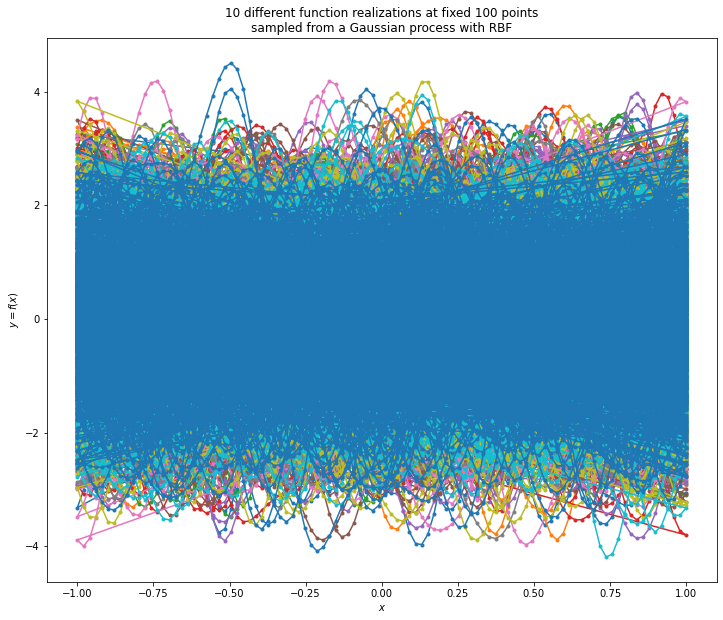

In [13]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, dt in enumerate(train_dl):
        ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), marker='o', markersize=3)
        if no > 9: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('10 different function realizations at fixed 100 points\n'
    'sampled from a Gaussian process with RBF')

___

In [14]:
import torch.optim as optim 

In [15]:
model = VAE(input_dim, hidden_dim1, hidden_dim2, z_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

## Training

In [17]:
from tqdm import tqdm, trange

In [20]:
t = trange(200)
for e in t:
    model.train()
    total_loss = 0
    for i, x in enumerate(train_dl):
        x = x[1].float().to(device)
        optimizer.zero_grad()
        x_pred, z_mu, z_sd = model(x)
        loss = compute_loss(x, x_pred, z_mu, z_sd)
        loss.backward()

        total_loss += loss.item()

        optimizer.step()
    t.set_description(f'Loss is {total_loss/(samples*input_dim):.3}')

Loss is 0.334: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it]
